<a href="https://colab.research.google.com/github/KillingVectorField/latent-sequence-model-EM-algorithm/blob/main/Assignment_1_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

# Utility function for reading in data from course Box folder

In [ ]:
import io
import requests
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder

#----------------------------------------
#from Chenxi Liu
#function for downloading sequence data from Box and converting to one-hot encoding
#note this function actually returns the summary statistics over the data, which is
#just the total number of each bases across all input sequences for our simple 
#latent variable model.
#

def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  '''
  this function by default returns a summary of all data.
  '''
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)
  
  for ii in range(len(categories)):
    data_ss[0,ii] = np.sum(data[:,:,ii])

  return data, data_ss

In [ ]:
XXss_sequences_padded, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')

100%|██████████| 357/357 [00:00<00:00, 2342.57it/s]


In [ ]:
N, L = XXss_sequences_padded.shape[:2]
P = 6

# Core EM code

In [ ]:
#----------------------------------------
# parameter initialization
# psi_0: a 4 * P matrix of background psi parameters
# psi_1: a 4 * P matrix of foreground psi parameters
# lmbda: an array of length L-P+1

def init_EM(seed=0):
  np.random.seed(seed=seed)
  lmbda = np.random.uniform(0, 1,size=(L-P+1,))
  lmbda /= lmbda.sum()
  psi_0 = np.random.uniform(0,1,size=(4,P))
  psi_0 /= psi_0.sum(axis=0)
  psi_1 = np.random.uniform(0,1,size=(4,P))
  psi_1 /= psi_1.sum(axis=0)
  theta = {'lmbda': lmbda, 'psi_0': psi_0, 'psi_1': psi_1}
  return(theta)

def E_step(theta, X):
  '''
  X is N*L*4
  Returns the N*(L-P+1) matrix E_q[C_{i,j}]
  '''
  # unnormalized_posteriors = theta['psi']*theta['lmbda']
  # normalized_posteriors = (unnormalized_posteriors.T/unnormalized_posteriors.sum(axis=1)).T
  # return(normalized_posteriors)
  EqC = np.zeros((N, L-P+1))
  lmbda = theta['lmbda']
  psi_ratio = theta['psi_1']/theta['psi_0']
  for i in range(len(X)):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)] # P*4
      EqC[i,j] = lmbda[j]* (Xij.T * psi_ratio).sum(axis=0).prod()
  return (EqC.T/EqC.sum(axis=1)).T

def M_step(X, EqC):
  '''
  compute MLE of psi, lambda
  return a dictionary containing psi, lambda
  X is N*L*4
  EqC is N*(L-P+1)
  '''
  lmbda = EqC.mean(axis=0)
  lmbda /= lmbda.sum()
  psi_1 = np.zeros((4,P))
  psi_0 = np.zeros((4,P))
  for i in range(N):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)].T # 4*P
      psi_1 += EqC[i,j] * Xij
      psi_0 += (1-EqC[i,j]) * Xij
  psi_1 /= N
  psi_0 /= N * (L-P)
  return {'lmbda':lmbda, 'psi_0':psi_0, 'psi_1':psi_1}


def loglikelihood(X, theta, EqC):
  '''
  compute log likelihood, given posteriors based off the current parameter set theta (so KL = 0)
  '''
  part_1 = EqC * np.log(theta['lmbda'])
  part_1[np.where(EqC == 0)] = 0
  part_1 = part_1.sum()
  part_2 = 0
  for i in range(N):
    for j in range(L-P+1):
      Xij = X[i,j:(j+P)].T # 4 * P
      if EqC[i,j]>0:
        weighted_X = Xij*np.log(theta['psi_1'])
        weighted_X[np.where(Xij==0)] = 0
        part_2 += EqC[i,j]*(weighted_X).sum()
      if EqC[i,j]<1:
        weighted_X = Xij*np.log(theta['psi_0'])
        weighted_X[np.where(Xij==0)] = 0
        part_2 += (1-EqC[i,j]) * (weighted_X).sum()
  expected_complete_LL = part_1 + part_2
  
  #entropy term calculation needs to be careful since 0log0 = 0, but coded naively will give nan
  qlogq = EqC * np.log(EqC);
  qlogq[np.where(EqC == 0)] = 0 #0log0 = 0
  entropy = - qlogq.sum()
  return (expected_complete_LL + entropy) #log likelihood = ELBO + entropy, when q=p
    

In [ ]:
theta = init_EM()

In [ ]:
EqC = E_step(theta,XXss_sequences_padded)

In [ ]:
theta_new = M_step(XXss_sequences_padded, EqC)

In [ ]:
loglikelihood(XXss_sequences_padded, theta_new, EqC)

-97693.87718448014

# Run EM

In [ ]:
def run_EM(init_theta, X, n_iter=100):
  record_loglik = []
  theta = init_theta
  for i in tqdm(range(n_iter)):
    EqC = E_step(theta, X)
    record_loglik.append(loglikelihood(X, theta, EqC))
    theta = M_step(X, EqC)
  return theta, EqC, record_loglik

In [ ]:
theta, EqC, record_loglik = run_EM(init_EM(0), XXss_sequences_padded)

 16%|█▌        | 16/100 [00:08<00:45,  1.85it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in multiply
 20%|██        | 20/100 [00:10<00:42,  1.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
 95%|█████████▌| 95/100 [00:48<00:02,  2.10it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


-96375.88347617154


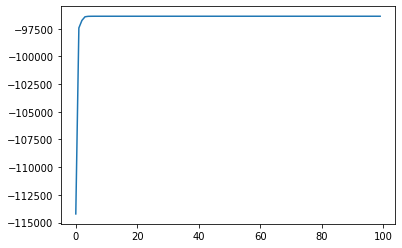

In [ ]:
print(record_loglik[-1])
plt.plot(record_loglik)
plt.show()

In [ ]:
record_loglik[:20]

[-114224.6319174538,
 -97431.89067424857,
 -96750.3326439708,
 -96423.36660937937,
 -96384.44790669254,
 -96377.92622705636,
 -96376.20880817805,
 -96375.92116440136,
 -96375.89284138112,
 -96375.88663321748,
 -96375.88462261115,
 -96375.88390872642,
 -96375.88364444062,
 -96375.88354353521,
 -96375.88350391897,
 -96375.88348793553,
 -96375.88348130668,
 -96375.88347847897,
 -96375.88347723939,
 -96375.88347667988]

We verify that the loglikelihood monotonically increases.

In [ ]:
result_list = [run_EM(init_EM(i), XXss_sequences_padded, n_iter=100) for i in range(30)]

 16%|█▌        | 16/100 [00:08<00:44,  1.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in multiply
 20%|██        | 20/100 [00:10<00:42,  1.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
 95%|█████████▌| 95/100 [00:48<00:02,  2.17it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/result_list.pickle', 'wb') as f:
with open('result_list.pickle', 'wb') as f:
    pickle.dump(result_list, f)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/result_list.pickle', 'rb') as f:
with open('result_list.pickle', 'rb') as f:
  result_list = pickle.load(f)

-96375.88347617154


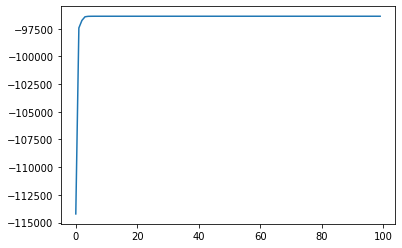

-96948.0830214341


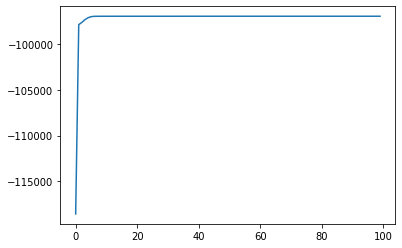

-96707.53135957156


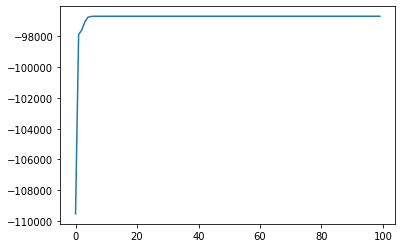

-96375.88347617154


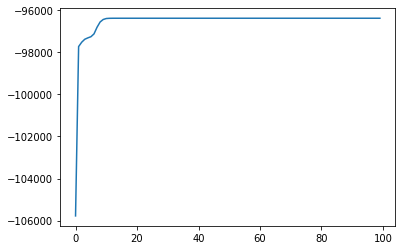

-96375.88347617154


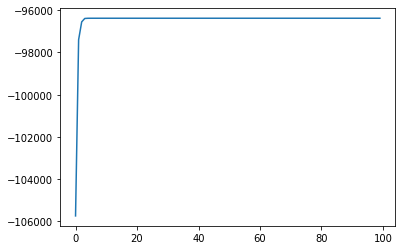

-96905.51743542914


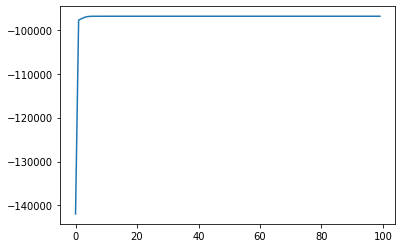

-96151.97815225786


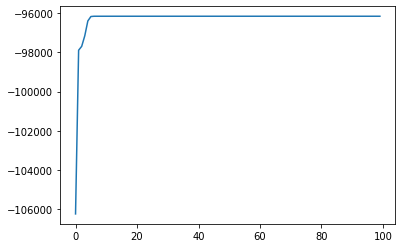

-96375.88347617154


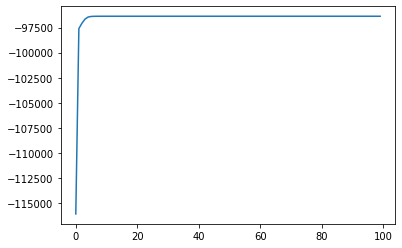

-96375.88347617154


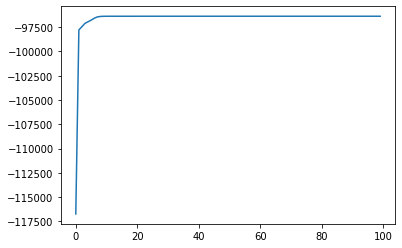

-95984.5139682446


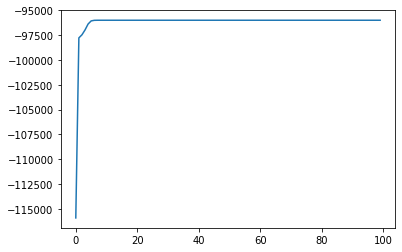

-96749.07219023762


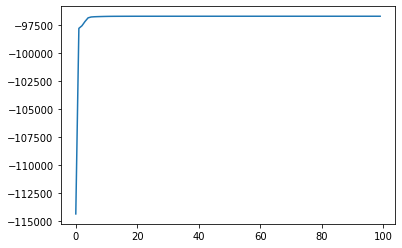

-96948.08302812045


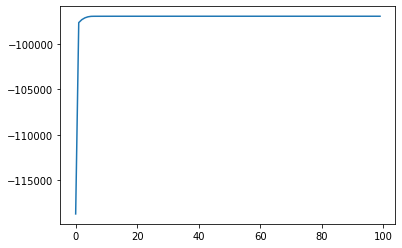

-96151.97815225786


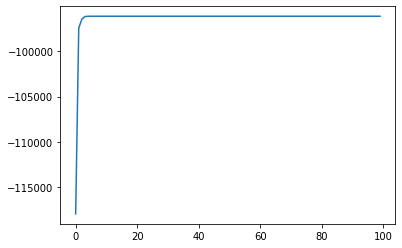

-96388.7399852924


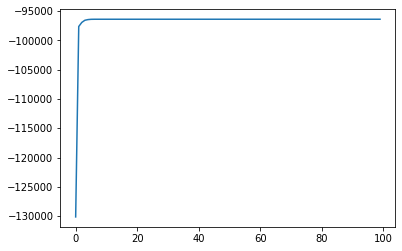

-96375.88347617154


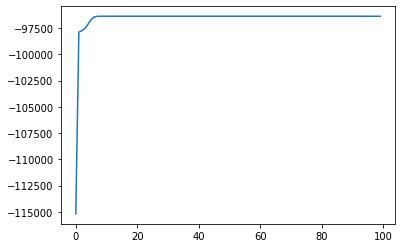

-95984.5139682446


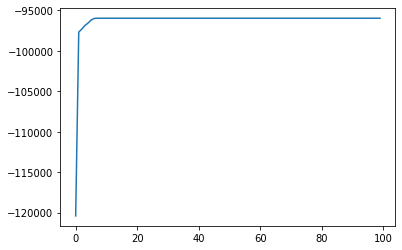

-96749.07219023454


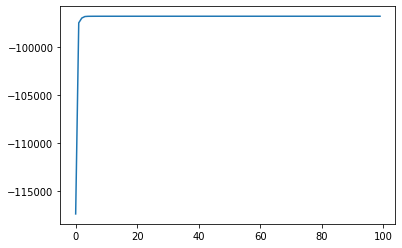

-96730.53415542089


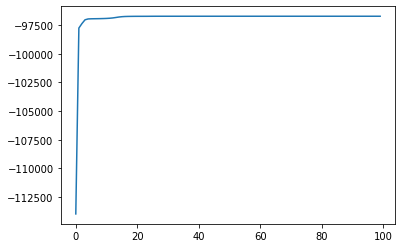

-96375.88347617154


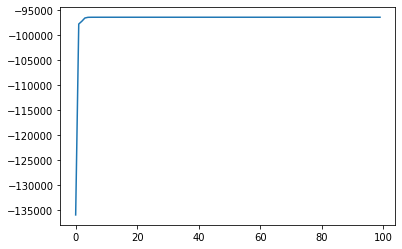

-96948.0830176708


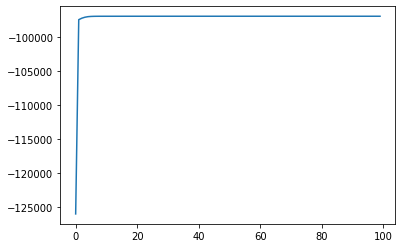

-95984.5139682446


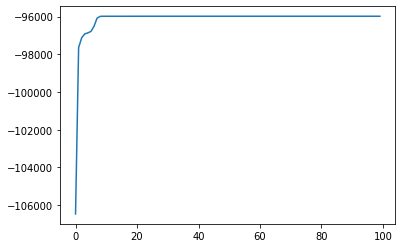

-97156.30427841


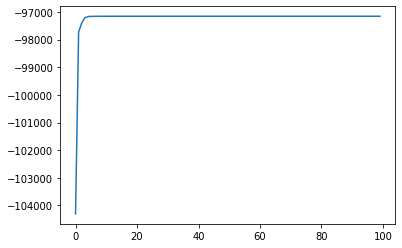

-96375.88347617154


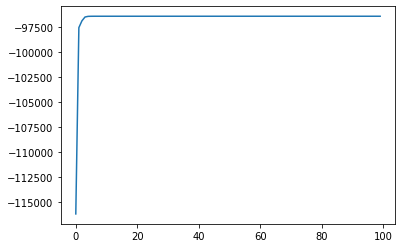

-96375.88347617154


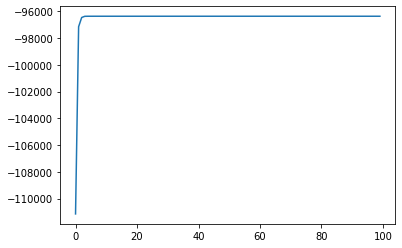

-96707.53135957166


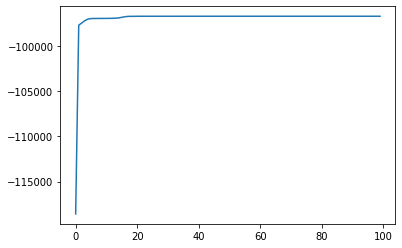

-96707.53135957157


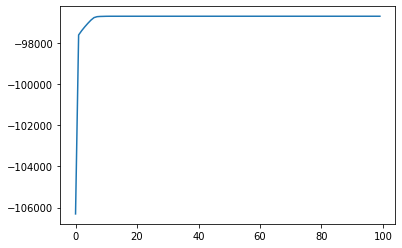

-96905.51728061009


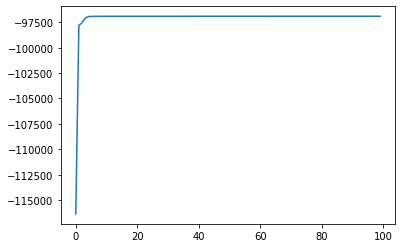

-96730.5341554021


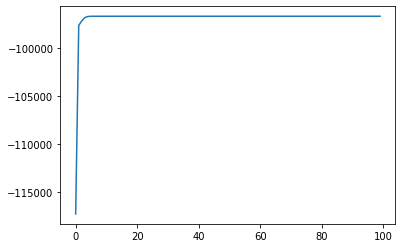

-96707.53135957156


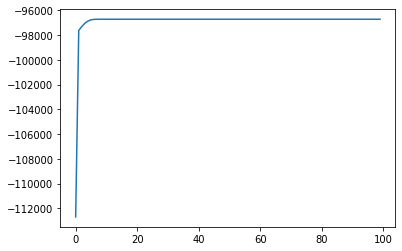

-96795.64487977607


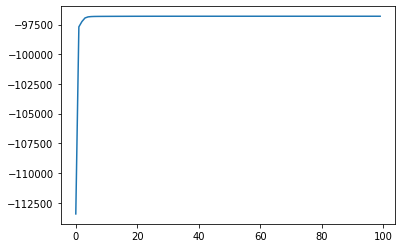

In [ ]:
for i in range(30):
  print(result_list[i][2][-1])
  plt.plot(result_list[i][2])
  plt.show()

In [ ]:
np.argmax([result_list[i][2][-1] for i in range(30)])

9

In [ ]:
result_list[9][2][-1]

-95984.5139682446